In [584]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import find_peaks, welch
from scipy.signal import butter, filtfilt
import ast
import matplotlib.pyplot as plt
import os

In [585]:
df = pd.read_csv(r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\waveform_decode_data\5c644be5c278761c.csv')

## Explore GE_ART Wave data and features

In [586]:
GE_ART = df[df['mg_name'] == 'GE_ART'].reset_index(drop=True)
GE_ART.loc[:,'binwave'] = GE_ART['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

In [587]:
ART = GE_ART['binwave']
ART_signal = np.concatenate(ART[:].values)

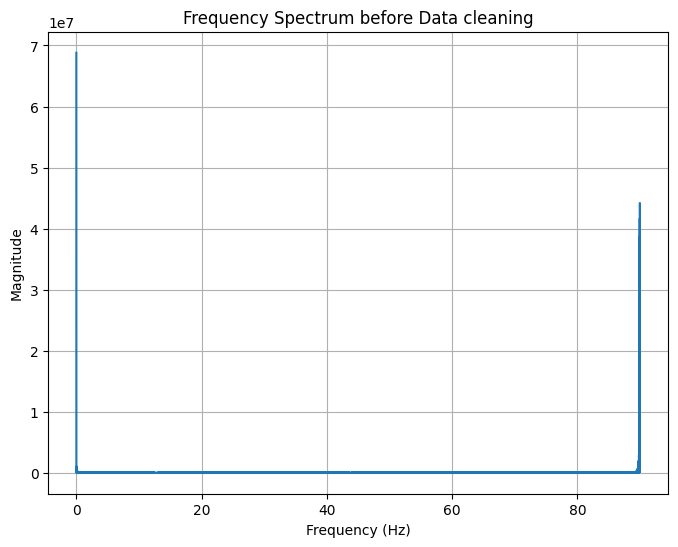

In [588]:
# Plot the raw signal frequency spectrum
fft_values = np.fft.fft(ART_signal)
fft_freq = np.fft.fftfreq(len(ART_signal), 1/180)

# only keep the positive frequencies
mask = fft_freq >= 0

plt.figure(figsize=(8, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_values[:len(fft_values)//2]))  # 只画正频率部分
plt.title("Frequency Spectrum before Data cleaning") 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

The result shows that there are two extreme low frequency and high frequency on two sides. We believe that is causing by tthe noise data such as external electromagnetic Interference or internal baeline drift. 

In [589]:
def ARC_butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def ARC_bandpass_filter(data, lowcut,highcut, fs, order):

    b,a = ARC_butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

fs = 180 # 180hz
ARC_lowcut = 10
ARC_highcut = 25
ARC_order = 6

ART_signal_filtered = ARC_bandpass_filter(ART_signal, ARC_lowcut, ARC_highcut, fs, ARC_order)

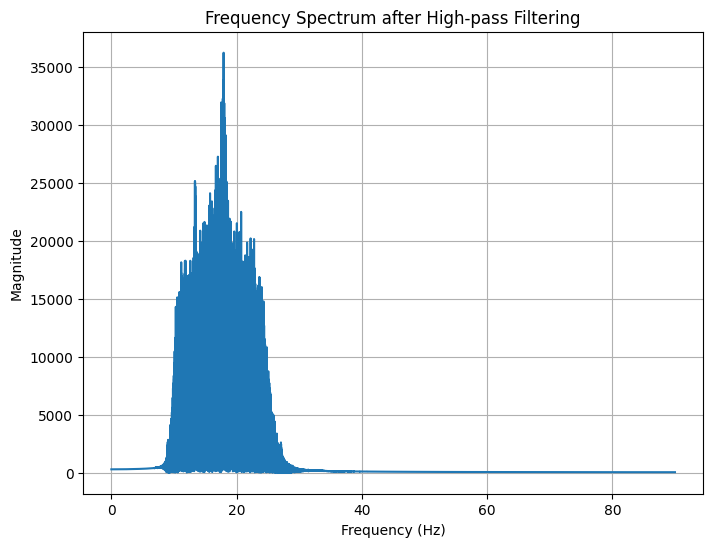

In [590]:
fft_values = np.fft.fft(ART_signal_filtered)
fft_freq = np.fft.fftfreq(len(ART_signal_filtered), 1/180)

mask = fft_freq >= 0


plt.figure(figsize=(8, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_values[:len(fft_values)//2]))  # 只画正频率部分
plt.title("Frequency Spectrum after High-pass Filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

The result output shows that We had successfully using bandpass filter the nosie data.

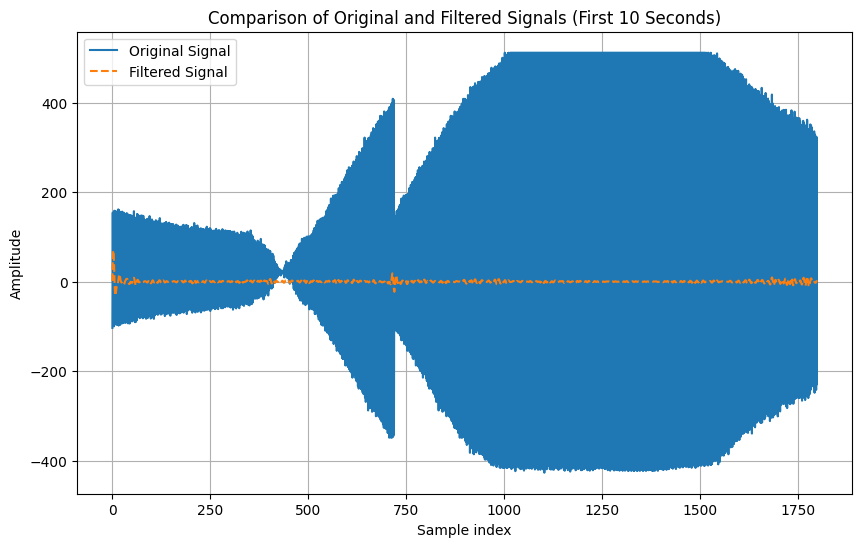

In [591]:
# Signal plot before and after filtered signals
plt.figure(figsize=(10, 6))
plt.plot(ART_signal[:fs * 10], label='Original Signal')  # 取前10秒
plt.plot(ART_signal_filtered[:fs * 10], label='Filtered Signal', linestyle='--')  # 取前10秒
plt.title('Comparison of Original and Filtered Signals (First 10 Seconds)')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


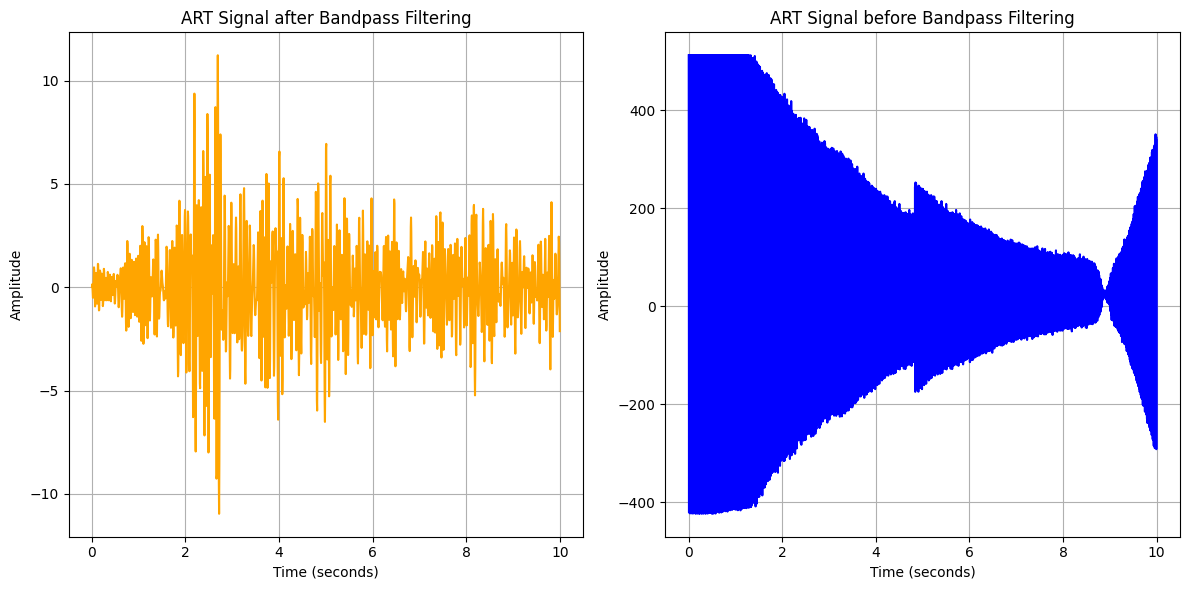

In [593]:
fs = 180 
# 1- 
seconds = 10 

# just randomly choose a start time during the surgery
start_time = 1290

signal_to_plot_filtered= ART_signal_filtered[start_time:start_time+fs * seconds]
signal_to_plot_original = ART_signal[start_time:start_time+fs * seconds]

# create the time axis
time_axis = np.linspace(0, seconds, len(signal_to_plot_filtered))

plt.figure(figsize=(12, 6))
# plot the signal after the bandpass filter
plt.subplot(1, 2, 1)

plt.plot(time_axis, signal_to_plot_filtered, label="Filtered Signal", color='orange')
plt.title('ART Signal after Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

# plot the signal before the bandpass filter
plt.subplot(1, 2, 2) 
plt.plot(time_axis, signal_to_plot_original, label="Filtered Signal", color='blue')
plt.title('ART Signal before Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show() 




In [594]:
# Then, using fourier transform to extract the frequency domain features
def ARC_compute_fft(signal, fs):

    n = len(signal)
    window = np.hamming(n)
    signal = signal * window
    fft_values = np.fft.fft(signal)


    fft_freq = np.fft.fftfreq(n, d=1/fs)

    return fft_freq[:n//2], np.abs(fft_values[:n//2])

# calculate the frequency domain features
def ARC_extract_frequency_features(signal,fft_values, fft_freq, fs):

    peaks, _ = find_peaks(signal, height=np.mean(signal))
    troughs, _ = find_peaks(-signal)

    if len(peaks) > 0 and len(troughs) > 0:
         systolic_peak = np.mean(signal[peaks])
         diastolic_peak = np.mean(signal[troughs])
         pulse_amplitude = systolic_peak - diastolic_peak

    else:
        systolic_peak = 0
        diastolic_peak = 0
        pulse_amplitude = 0

    peak_frequency = fft_freq[np.argmax(fft_values)]    
    spectral_energy = np.mean(fft_values**2)
    bandwidth = np.max(fft_freq[fft_values > np.median(fft_values)])

    return {
        'systolic_peak': systolic_peak,
        'diastolic_peak': diastolic_peak,
        'pulse_amplitude': pulse_amplitude,
        'peak_frequency': peak_frequency,
        'spectral_energy': spectral_energy,
        'bandwidth': bandwidth
    }

# store the features in a list
def ARC_features(ART_signal, fs, order):

    filtered_signal = ARC_bandpass_filter(ART_signal, lowcut=0.5, highcut=20, fs = fs, order = order)

    fft_freq, fft_values = ARC_compute_fft(filtered_signal, fs = fs)
    freq_features = ARC_extract_frequency_features(fft_values,fft_values, fft_freq, fs)

    result_array = [round(float(val),2) for val in freq_features.values()]

    return result_array

fs = 180 # 180hz
ARC_lowcut = 10
ARC_highcut = 25
ARC_order = 6

result = ARC_features(ART_signal, fs, ARC_order)
print(result)

[5048.01, 633.42, 4414.6, 7.36, 4575890.55, 45.34]


The result shows a extreme high value of systolic peak and diastolic peak, these may cause by there are still lots of nosie data contained in the dataset that we havn't have ability to clean it.

## Explore GE_ECG wave

In [595]:
GE_ECG = df[df['mg_name'] == 'GE_ECG'].reset_index(drop=True)
GE_ECG.loc[:,'binwave'] = GE_ECG['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))
ECG = GE_ECG['binwave']
ECG_signal = np.concatenate(ECG[:].values)
ECG_signal

array([ 1653., -1243.,  1579., ..., -1555.,  1864., -1562.])

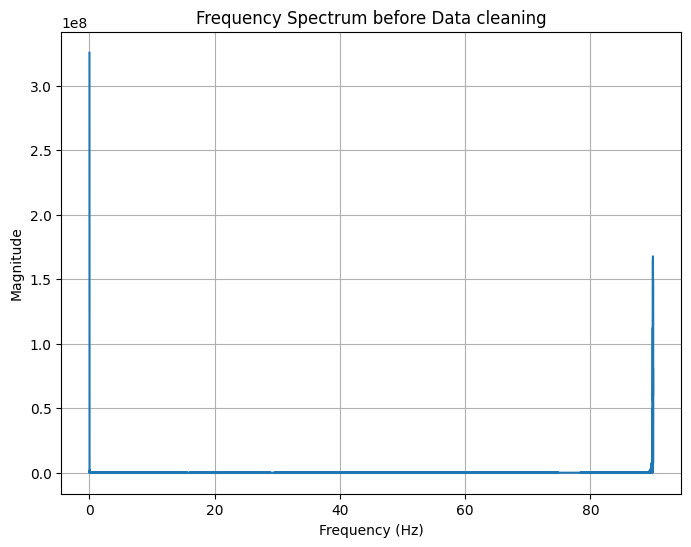

In [596]:
# Plot the raw signal frequency spectrum
fft_values = np.fft.fft(ECG_signal)
fft_freq = np.fft.fftfreq(len(ECG_signal), 1/180)

# only keep the positive frequencies
mask = fft_freq >= 0

plt.figure(figsize=(8, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_values[:len(fft_values)//2]))  
plt.title("Frequency Spectrum before Data cleaning") 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

The plots results are extremely high on both sides which indiciates tha exist of noise data which requires to filter out

In [597]:
fs = 180 # 180hz
ECG_lowcut = 1
ECG_highcut = 12
ECG_order = 6

def ECG_butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def ECG_bandpass_filter(data, lowcut,highcut, fs, order):

    b,a = ECG_butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


ECG_signal_filtered = ECG_bandpass_filter(ECG_signal, ECG_lowcut, ECG_highcut, fs, ECG_order)


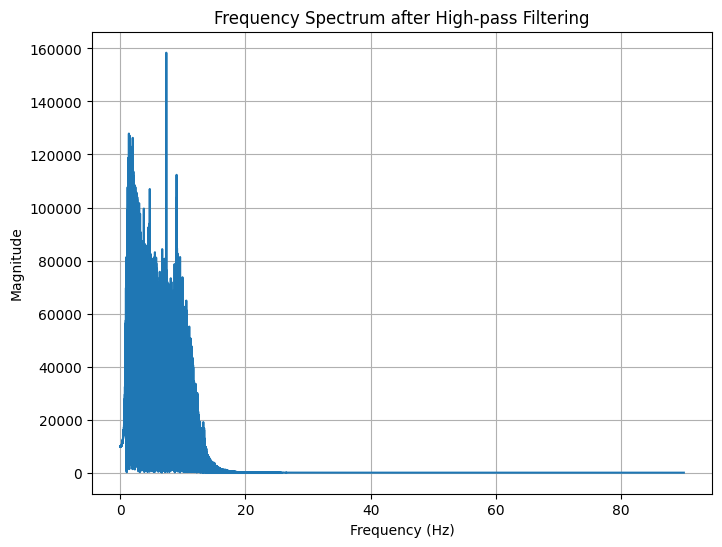

In [598]:
fft_values = np.fft.fft(ECG_signal_filtered)
fft_freq = np.fft.fftfreq(len(ECG_signal_filtered), 1/180)

mask = fft_freq >= 0


plt.figure(figsize=(8, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_values[:len(fft_values)//2]))  # 只画正频率部分
plt.title("Frequency Spectrum after High-pass Filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

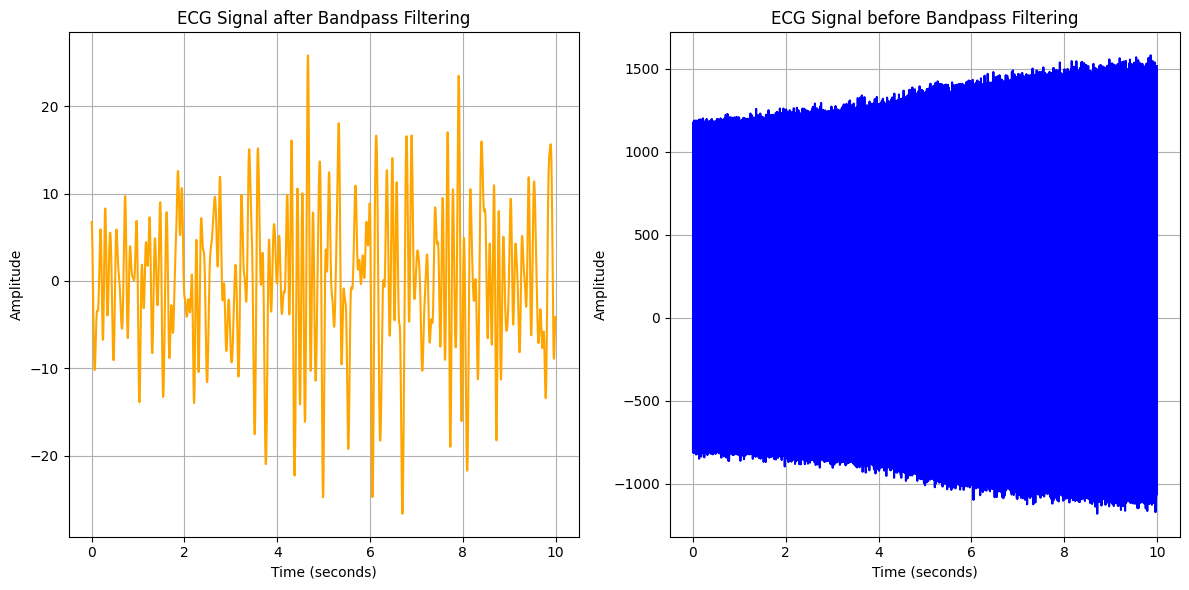

In [599]:
# Hz:180
fs = 180 
# 10 seconds of time window 
seconds = 10 

# just randomly choose a start time during the surgery
start_time = 24314

signal_to_plot_filtered= ECG_signal_filtered[start_time:start_time+fs * seconds]
signal_to_plot_original = ECG_signal[start_time:start_time+fs * seconds]

# create the time axis
time_axis = np.linspace(0, seconds, len(signal_to_plot_filtered))

plt.figure(figsize=(12, 6))
# plot the signal after the bandpass filter
plt.subplot(1, 2, 1)

plt.plot(time_axis, signal_to_plot_filtered, label="Filtered Signal", color='orange')
plt.title('ECG Signal after Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

# plot the signal before the bandpass filter
plt.subplot(1, 2, 2) 
plt.plot(time_axis, signal_to_plot_original, label="Filtered Signal", color='blue')
plt.title('ECG Signal before Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show() 


### Explore frequency domain features from ECG

In [601]:
def ECG_extract_features(signal,fs):


    #set the number of samples that equals to 5 seconds of time windows
    nperseg = int(750)
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)

    # extract features based on frequency components
    qrs_mask = (freqs >= 1) & (freqs <= 20)
    vf_mask = (freqs >= 4) & (freqs <= 7)
    vt_msg_mask = (freqs < 4)

    # compute the power in each frequency band
    # Chhose the mean value of the power in the frequency since different patient may have different surgery time
    qrs_freq_power = np.mean(psd[qrs_mask])
    vf_freq_power = np.mean(psd[vf_mask])
    vt_freq_power = np.mean(psd[vt_msg_mask])

    qrs_peak_freq = freqs[np.argmax(psd[qrs_mask])]

    # additional statistical features
    magnitude = np.abs(signal)
    std_magnitude = np.std(magnitude)

    return {
        'qrs_freq_power': qrs_freq_power,
        'vf_freq_power': vf_freq_power,
        'vt_freq_power': vt_freq_power,
        'qrs_peak_freq': qrs_peak_freq,
        'std_magnitude': std_magnitude
    }


In [602]:
ECG_signal_filtered = ECG_bandpass_filter(ECG_signal, ECG_lowcut, ECG_highcut, fs, ECG_order)
result = ECG_extract_features(ECG_signal_filtered, fs)
result = [round(float(val),2) for val in result.values()]
print(result)

[2.06, 3.55, 3.42, 0.24, 7.59]


### Create function to using loops to extract features from every files

In [604]:
folder_path = r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\waveform_decode_data'

columns = ['LOG_ID','ARC_wavefeature','ECG_wavefeature']

output_df = pd.DataFrame(columns=columns)

i = 1
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file))
   
    # Used the code from previous cells to extract the ART signal features
    GE_ART = df[df['mg_name'] == 'GE_ART'].reset_index(drop=True)
    GE_ART.loc[:,'binwave'] = GE_ART['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))
    ART = GE_ART['binwave']
    ART_signal = np.concatenate(ART[:].values)

    fs = 180 # 180hz
    ARC_lowcut = 10
    ARC_highcut = 25
    ARC_order = 6
    ARC_result = ARC_features(ART_signal, fs, ARC_order)


    # Used the code from previous cells to extract the ECG signal features
    GE_ECG = df[df['mg_name'] == 'GE_ECG'].reset_index(drop=True)
    GE_ECG.loc[:,'binwave'] = GE_ECG['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))
    ECG = GE_ECG['binwave']
    ECG_signal = np.concatenate(ECG[:].values)

    fs = 180 # 180hz
    ECG_lowcut = 1
    ECG_highcut = 12
    ECG_order = 6
    ECG_signal_filtered = ECG_bandpass_filter(ECG_signal, ECG_lowcut, ECG_highcut, fs, ECG_order)
    ECG_result = ECG_extract_features(ECG_signal_filtered, fs)
    ECG_result = [round(float(val),2) for val in ECG_result.values()]

    file_name = os.path.splitext(file)[0]

    # store the features result in the dataframe based on the file name
    new_row = pd.DataFrame({'LOG_ID': [file_name], 'ARC_wavefeature': [ARC_result], 'ECG_wavefeature': [ECG_result]})
    output_df = pd.concat([output_df, new_row], ignore_index=True)  

    i = i+1
    print(f"Currently, {i} files have been processed")


Currently, 2 files have been processed
Currently, 3 files have been processed
Currently, 4 files have been processed
Currently, 5 files have been processed
Currently, 6 files have been processed
Currently, 7 files have been processed
Currently, 8 files have been processed
Currently, 9 files have been processed
Currently, 10 files have been processed
Currently, 11 files have been processed
Currently, 12 files have been processed
Currently, 13 files have been processed
Currently, 14 files have been processed
Currently, 15 files have been processed
Currently, 16 files have been processed
Currently, 17 files have been processed
Currently, 18 files have been processed
Currently, 19 files have been processed
Currently, 20 files have been processed
Currently, 21 files have been processed
Currently, 22 files have been processed
Currently, 23 files have been processed
Currently, 24 files have been processed
Currently, 25 files have been processed
Currently, 26 files have been processed
Currentl

In [605]:
output_df

,LOG_ID,ARC_wavefeature,ECG_wavefeature
0,00fbb475a02e94c3,"[252.12, 32.0, 220.11, 7.25, 12081.74, 50.28]","[322.92, 434.57, 869.92, 0.0, 69.76]"
1,011e00acde3a3342,"[16279.61, 1685.74, 14593.87, 8.29, 185471079....","[0.64, 0.6, 2.27, 0.0, 6.3]"
2,0124e746e00e3b4a,"[1520.99, 189.51, 1331.48, 1.55, 415709.79, 48...","[1452.14, 1582.2, 5244.57, 0.24, 158.34]"
3,01953a9111bff808,"[1304.1, 171.75, 1132.35, 14.92, 428938.54, 45...","[0.17, 0.17, 0.61, 0.0, 2.61]"
4,01dc302bc8104d42,"[1958.25, 290.57, 1667.67, 0.55, 1068265.31, 4...","[0.36, 0.47, 0.91, 0.0, 4.25]"
...,...,...,...
1143,ff5c0ba0edf25cf2,"[3465.44, 476.34, 2989.1, 0.64, 2393360.64, 45...","[1.1, 1.59, 1.99, 0.0, 4.75]"
1144,ff9d82108883542a,"[207.4, 26.07, 181.34, 7.36, 7376.23, 46.12]","[0.01, 0.02, 0.02, 0.24, 0.48]"
1145,ffc167ad138cf4a7,"[2423.18, 309.71, 2113.47, 0.71, 1715274.39, 4...","[0.52, 0.65, 1.22, 7.92, 6.55]"
1146,ffcb585a8a103c92,"[173.08, 26.02, 147.06, 3.2, 5698.56, 45.13]","[0.01, 0.01, 0.01, 1.92, 0.44]"


In [606]:
arc_columns = ['systolic_peak', 'diastolic_peak', 'pulse_amplitude', 'arc_peak_frequency', 'arc_spectral_energy', 'arc_bandwidth']
ecg_columns = ['qrs_freq_power', 'vf_freq_power', 'vt_freq_power', 'qrs_peak_freq', 'ecg_std_magnitude']

output_df[arc_columns] = output_df['ARC_wavefeature'].apply(pd.Series)
output_df[ecg_columns] = output_df['ECG_wavefeature'].apply(pd.Series)


output_df.drop(['ARC_wavefeature', 'ECG_wavefeature'], axis=1, inplace=True)
output_df


,LOG_ID,systolic_peak,diastolic_peak,pulse_amplitude,arc_peak_frequency,arc_spectral_energy,arc_bandwidth,qrs_freq_power,vf_freq_power,vt_freq_power,qrs_peak_freq,ecg_std_magnitude
0,00fbb475a02e94c3,252.12,32.00,220.11,7.25,1.208174e+04,50.28,322.92,434.57,869.92,0.00,69.76
1,011e00acde3a3342,16279.61,1685.74,14593.87,8.29,1.854711e+08,47.16,0.64,0.60,2.27,0.00,6.30
2,0124e746e00e3b4a,1520.99,189.51,1331.48,1.55,4.157098e+05,48.78,1452.14,1582.20,5244.57,0.24,158.34
3,01953a9111bff808,1304.10,171.75,1132.35,14.92,4.289385e+05,45.24,0.17,0.17,0.61,0.00,2.61
4,01dc302bc8104d42,1958.25,290.57,1667.67,0.55,1.068265e+06,45.21,0.36,0.47,0.91,0.00,4.25
...,...,...,...,...,...,...,...,...,...,...,...,...
1143,ff5c0ba0edf25cf2,3465.44,476.34,2989.10,0.64,2.393361e+06,45.27,1.10,1.59,1.99,0.00,4.75
1144,ff9d82108883542a,207.40,26.07,181.34,7.36,7.376230e+03,46.12,0.01,0.02,0.02,0.24,0.48
1145,ffc167ad138cf4a7,2423.18,309.71,2113.47,0.71,1.715274e+06,45.34,0.52,0.65,1.22,7.92,6.55
1146,ffcb585a8a103c92,173.08,26.02,147.06,3.20,5.698560e+03,45.13,0.01,0.01,0.01,1.92,0.44


The waveform data is too large and using sharding storage. Therefore, the waveform is been processed seperatly on differnt laptops, and required to concat to generate a complete waveform feature extraction results

In [ ]:
file_path = r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\output_part1.csv'
output_1 = pd.read_csv(file_path)
output_df = pd.concat([output_1, output_df], ignore_index=True)


In [607]:


folder_path = r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\processedData'
file_name = 'waveform_features.csv'

full_path = f'{folder_path}\\{file_name}'
output_df.to_csv(full_path, index=False)